Professor, eu poderia dizer que tentei realizar este tutorial: https://docs.opencv.org/master/d5/de7/tutorial_dnn_googlenet.html que o senhor sugeriu, e dizer que não consegui. Mas a verdade é que nem tentei fazê-lo, pois teria que montar todo o ambiente para roda o Opencv em C++, visto que meu ambiente é montado para códigos python, como também utilizo a plataforma Google Colaboratory para execução dos algoritmos mais pesados, como é o caso da atividade proposta desta aula(26), onde também roda em python. Portanto, para poupar-me de um esforço maior, estou reproduzindo o tutorial proposto em python no Google Colaboratory, utilizando os mesmos conceitos do tutorial sugerido pelo senhor: desenvolver uma CNN e utilizar uma rede já treinada.

- Rede: Inception V3
- Data: dogs.vs.cats


Link para tutorial seguindo nesta implementação: https://medium.com/analytics-vidhya/transfer-learning-using-inception-v3-for-image-classification-86700411251b

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-05-28 04:00:49--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  92.0MB/s    in 0.7s    

2020-05-28 04:00:50 (92.0 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [5]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [0]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')

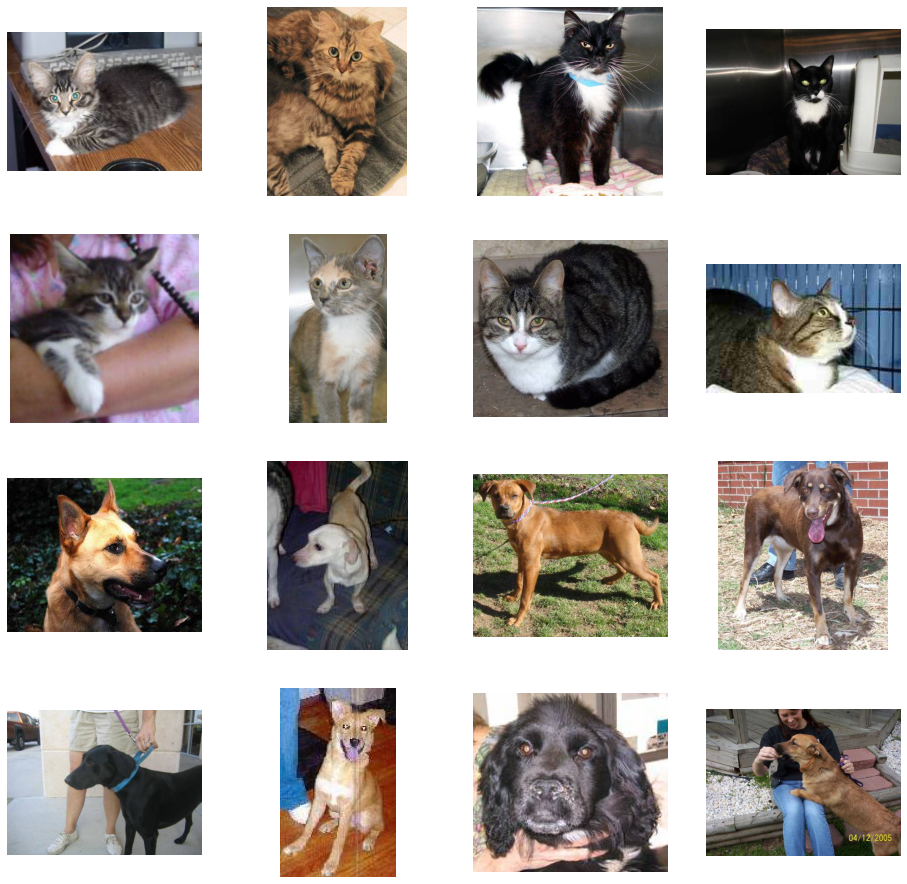

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [10]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
87916544/87910968 [==============================] - 3s 0us/step


In [0]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.800):
      print("\nReached 80.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [13]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 50,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/50
Epoch 1/50
100/100 - 19s - loss: 0.4902 - acc: 0.7745 - val_loss: 0.3173 - val_acc: 0.9400
Epoch 2/50
Epoch 1/50
100/100 - 18s - loss: 0.4707 - acc: 0.7880 - val_loss: 0.3529 - val_acc: 0.9380
Epoch 3/50
Epoch 1/50

Reached 80.0% accuracy so cancelling training!
100/100 - 18s - loss: 0.4509 - acc: 0.8065 - val_loss: 0.4373 - val_acc: 0.9170
